In [1]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas as pd
import numpy as np
import seaborn

In [3]:
T1 = SuchTree( 'SuchTree/tests/test.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

In [ ]:
T1 = SuchTree( 'SuchTree/tests/test.tree' )
T2 = SuchTree( 'SuchTree/tests/test.tree' )
links = pd.DataFrame( np.random.random_integers( 0, 3, size=(14,14) ), index=T1.leafs.keys(), columns=T1.leafs.keys() )

In [4]:
SLT = SuchLinkedTrees( T1, T2, links )
#SLT = SuchLinkedTrees( T1, T2, links )

140522318968864 allocating columns in 3873945656
bulding default subset.
bulding default link list.


In [ ]:
SLT.dump_table()

In [ ]:
SLT.linkmatrix

In [ ]:
SLT.linklist[0,0]

In [ ]:
result = SLT.linked_distances()

seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [ ]:
SLT.TreeB.get_internal_nodes()

In [5]:
SLT.TreeB.get_leafs( 7027 )

array([6936, 7040, 7046, 7052, 6880, 6938, 6940, 6942, 6994, 7028, 7034,
       7042, 7044, 7048, 7050, 7054, 7056, 6882, 6944, 6950, 6996, 6998,
       7014, 7030, 7032, 7036, 7038, 6884, 6886, 6926, 6932, 6934, 6946,
       6948, 6952, 6954, 7000, 7008, 6914, 6916, 6918, 6920, 6928, 6930,
       6972, 6986, 7002, 7010, 7012, 7016, 7024, 7026, 6888, 6890, 6892,
       6922, 6924, 6956, 6958, 6960, 6962, 6964, 6974, 6980, 6992, 7004,
       7006, 7022, 6894, 6896, 6898, 6906, 6966, 6976, 6978, 6982, 6984,
       6988, 6990, 7018, 7020, 6900, 6908, 6968, 6970, 6902, 6904, 6910,
       6912])

In [6]:
SLT.subset( 7027 )
print SLT.subset_size, SLT.subset_n_links

89 245


In [7]:
print SLT.col_ids
print SLT.subset_columns
print SLT.subset_leafs

[ 77012 106174 100632 ...,  60496  40312  67012]
[37633 25708 51090 17894 20203 28821 30994 51224 29565 37352 27576 37745
  5083  7167 29305 21102  2900 45778 12785 43434 28605 50204 42422 37275
 33623 28599   702 22655  8894 16086 52753  7036 22235 29536 25752 19840
 25913 45302  7254 11458 46359 17008 17559 13866 13594 30210 42254 35039
 51425 38488 26463 19919 21829 33133  7334 23312 43075 15132 11588 14504
 38995 14011 31929 26999 51838  5457 31613 17337 50120 27007 49497 28213
 45249 47995 41296 44556  4512  5212 16829 50626 26848 50728   386 32460
 19676 48859 24163  5066 36179]
[6936 7040 7046 7052 6880 6938 6940 6942 6994 7028 7034 7042 7044 7048 7050
 7054 7056 6882 6944 6950 6996 6998 7014 7030 7032 7036 7038 6884 6886 6926
 6932 6934 6946 6948 6952 6954 7000 7008 6914 6916 6918 6920 6928 6930 6972
 6986 7002 7010 7012 7016 7024 7026 6888 6890 6892 6922 6924 6956 6958 6960
 6962 6964 6974 6980 6992 7004 7006 7022 6894 6896 6898 6906 6966 6976 6978
 6982 6984 6988 6990 7018 70

In [8]:
SLT.linklist

array([[6936,    2],
       [7040,    0],
       [7040,    8],
       [7046,    8],
       [7052,    0],
       [7052,    8],
       [6880,    2],
       [6880,   20],
       [6880,   10],
       [6880,    0],
       [6880,   12],
       [6880,    8],
       [6938,    2],
       [6938,    0],
       [6940,    0],
       [6940,   18],
       [6940,    8],
       [6942,    8],
       [6994,    0],
       [6994,   18],
       [7028,    2],
       [7028,    8],
       [7028,   26],
       [7034,   12],
       [7034,    0],
       [7042,    2],
       [7042,    8],
       [7044,    0],
       [7044,   16],
       [7044,   20],
       [7044,   24],
       [7044,    8],
       [7048,    2],
       [7048,   14],
       [7048,    0],
       [7048,   16],
       [7048,   24],
       [7048,    8],
       [7050,    2],
       [7050,    0],
       [7054,   12],
       [7054,    0],
       [7054,   22],
       [7054,   10],
       [7054,   20],
       [7056,    8],
       [7056,   24],
       [6882,

In [ ]:
size = (SLT.subset_size*(SLT.subset_size-1))/2

ids_a = zeros( (size, 2), dtype=int )
ids_b = zeros( (size, 2), dtype=int )
k=0
for i in xrange( SLT.subset_size ) :
    for j in xrange( i ) :
        ids_a[ k, 0 ] = SLT.linklist[ i, 1 ]
        ids_a[ k, 1 ] = SLT.linklist[ j, 1 ]
        ids_b[ k, 0 ] = SLT.linklist[ i, 0 ]
        ids_b[ k, 1 ] = SLT.linklist[ j, 0 ]
        k += 1

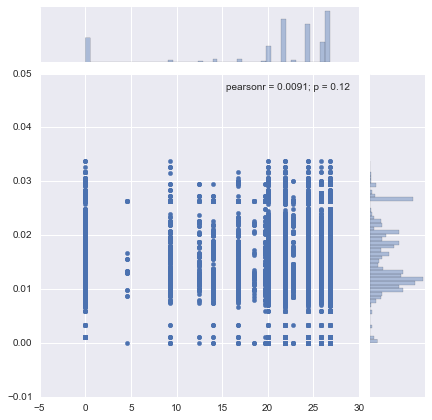

In [10]:
result = SLT.linked_distances()

seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [ ]:
SLT.get_column_leafs( 0, as_row_ids=True )

In [ ]:
SLT.get_column_links( 0 )

In [ ]:
s = links[ links.index[0] ]
map( list(SLT.col_ids).index, map( lambda x : T1.leafs[x],  s[ s > 0 ].index ) )

In [ ]:
set((1,2,3)) == set((1,2,3))

In [ ]:
for a,b, in zip( s.index, SLT.row_names ) :
    print a == b

In [ ]:
for n in xrange( 14 ) :
    for a,b in zip( SLT.linkmatrix[0], SLT.get_column_links(0) ) :
        print a == b

In [ ]:
for col in SLT.col_names :
    for row in SLT.row_names :
        col_id = SLT.col_names.index(col)
        row_id = SLT.row_names.index(row)
        print bool(links[col][row]) == SLT.linkmatrix[col_id][row_id]

In [14]:
%%cython

cdef extern from "stdlib.h":
    long int random()

def foo_rand() :
    return random()

In [27]:
foo_rand()

374727854

In [16]:
random

<module 'numpy.random' from '/home/russell/opt/local/lib/python2.7/site-packages/numpy/random/__init__.pyc'>

In [45]:
%%cython

cdef class rng :
    cdef unsigned long x
    
    def __cinit__( self ) :
        self.x = 10
     
    cdef unsigned long _xorshift64star( self ) :
        self.x ^= self.x >> 12 # a
        self.x ^= self.x << 25 # b
        self.x ^= self.x >> 27 # c
        #return self.x * 2685821657736338717
        return self.x
    
    def xorshiftstar( self ) :
        return self._xorshift64star()

In [47]:
R = rng()

In [50]:
R.xorshiftstar()

34342146521776154L